In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import linregress
import os
import seaborn as sns

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [3]:
# Target variable
target = '사용전력량'

# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]

# Outlier removal
if target in df.columns:
    target_value = len(df)
    df = df[df[target] >= 15000]
    removed_target_value = target_value - len(df)
    print(f"Removed {removed_target_value} rows where {target} < 15000.")
else:
    print(f"Warning: '{target}' column not found.")

'''
# Outlier removal
if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'Precipitation (mm)'} > 10.")
else:
    print(f"Warning: '{'Precipitation (mm)'}' column not found.")
'''

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

Removed 4 rows where 사용전력량 < 15000.


In [4]:
# Feature engineering
df['slag time'] = df['소요시간_추가1'] + df['소요시간_추가2'] + df['소요시간_산화'] + df['소요시간_환원']
df['slag rate'] = df['CaO'] / 0.24 / df['slag time']

other_variables = ['연회회수', '란스O2_주요장입', '버너O2_주요장입', '버너오일_주요장입', 'PSAO2_주요장입', 
                   '란스O2_로 보수/수리', '버너O2_로 보수/수리', '버너오일_로 보수/수리', 'PSAO2_로 보수/수리', 
                  ]

input_variables = ['EAF측온회수', 'CaO', 'FeSi75', 'SiMn', 'SiC', 'C-inj(佐山)', '봉지포장카본ﾝ', '알루미늄 재(ﾌﾚ)', '알루미늄 재(종이)', '취부재',
                   'SiMn0-20'
                  ]
weather_variables = ['Pressure_Local (hPa)', 'Pressure_SeaLevel (hPa)', 'Precipitation (mm)',  'Temperature (°C)', 'Relative Humidity (%)',
                     'WindSpeed_Avg (m/s)', 'WindSpeed_Max (m/s)', 'Sunshine Duration (min)', 'precipitation_last24', 'precipitation_last48',
                     'precipitation_last72', 'precipitation_last24_lag24', 'precipitation_last24_lag48', 'drying_index'
                    ]

chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
son_variables = [col for col in df.columns if '손' in col]
ja_variables = [col for col in df.columns if '자' in col and '자동차' not in col and '부자재' not in col]

variables = weather_variables + chin_variables + other_variables

In [5]:
X = df[variables]
y = df[target]

# Sequential train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# What I'm using

r-value between '버너오일_로 보수/수리' and '수율': -0.4165


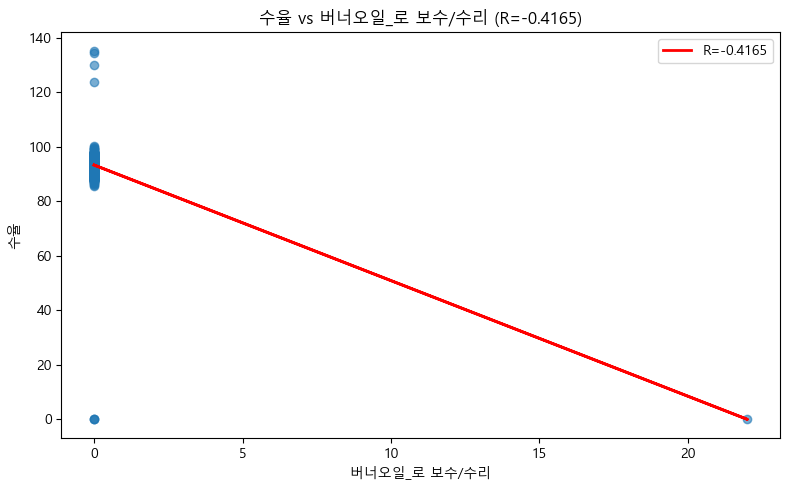

In [6]:
# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df['A_plus_B'] = df['비통전시간_주요장입'] + df['통전시간_주요장입']
df['slag time'] = df['소요시간_추가1'] + df['소요시간_추가2'] + df['소요시간_산화'] + df['소요시간_환원']
df['slag rate'] = df['CaO'] / 0.24 / df['slag time']

# Set your target and variable of interest
col = '버너오일_로 보수/수리'  # change to the column you want to check
target = '수율'
    
# Check if columns exist
if col not in df.columns:
    print(f"'{col}' not found.")
else:
    x = df[col]
    y = df[target]

    # Drop missing values
    valid = x.notna() & y.notna()
    x = x[valid]
    y = y[valid]

    # Optional: Remove outliers
    def remove_outliers(series):
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return series[(series >= lower) & (series <= upper)]

    x_filtered = remove_outliers(x)
    y_filtered = y.loc[x_filtered.index]
    y_filtered = remove_outliers(y_filtered)
    x_filtered = x_filtered.loc[y_filtered.index]

# Compute regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print r-value
print(f"r-value between '{col}' and '{target}': {r_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, slope * x + intercept, color='red', linewidth=2, label=f'R={r_value:.4f}')
plt.xlabel(col)
plt.ylabel(target)
plt.title(f'{target} vs {col} (R={r_value:.4f})')
plt.legend()
plt.tight_layout()
plt.show()

# Time Series

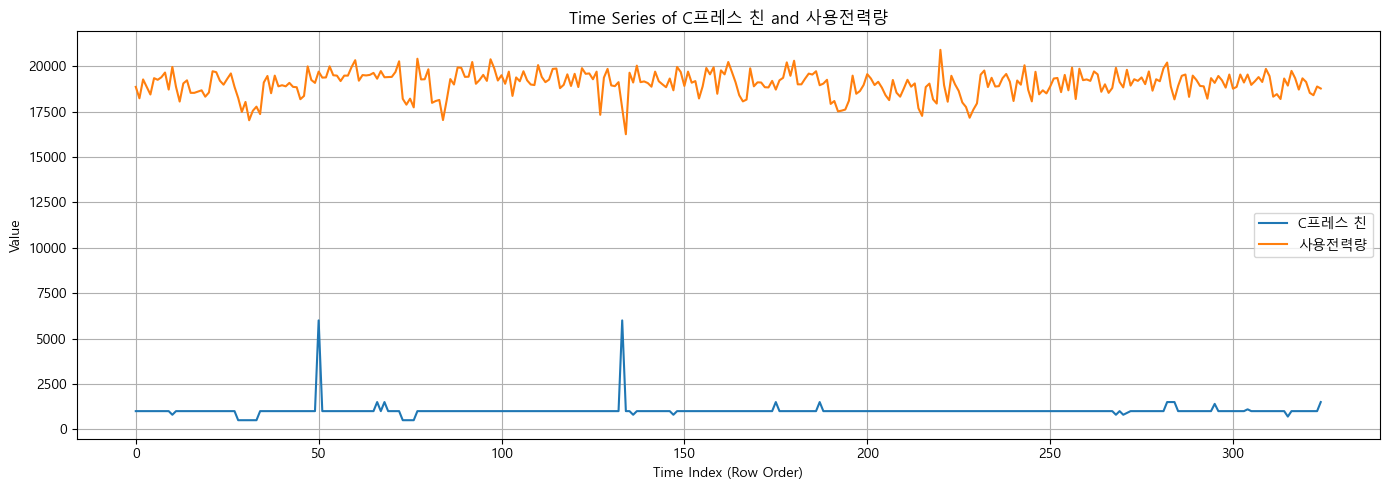

In [7]:
# Check if both columns exist
if 'C프레스 친' in df.columns and '사용전력량' in df.columns:
    # Drop rows with missing values in either column
    ts_df = df[['C프레스 친', '사용전력량']].dropna().reset_index(drop=True)

    # Create a sequential time index
    ts_df['Time Index'] = range(len(ts_df))

    # Plot the raw values
    plt.figure(figsize=(14, 5))
    plt.plot(ts_df['Time Index'], ts_df['C프레스 친'], label='C프레스 친')
    plt.plot(ts_df['Time Index'], ts_df['사용전력량'], label='사용전력량')
    plt.xlabel('Time Index (Row Order)')
    plt.ylabel('Value')
    plt.title('Time Series of C프레스 친 and 사용전력량')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("One or both columns ('C프레스 친', '사용전력량') are missing from the dataframe.")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

target = 'CC_P'

# Step 1: Select only numeric columns, including the target
numeric_df = df.select_dtypes(include=[np.number])

# Step 2: Drop rows where target is missing
numeric_df = numeric_df.dropna(subset=[target])

# Step 3: Filter out columns with too few non-null values (< 20% of rows)
min_non_null_ratio = 0.2
min_count = int(len(numeric_df) * min_non_null_ratio)

valid_cols = [col for col in numeric_df.columns 
              if numeric_df[col].notnull().sum() >= min_count]

# Step 4: Subset the DataFrame to those valid columns
filtered_df = numeric_df[valid_cols]

# Step 5: Compute correlations
correlations = filtered_df.corr()[target].drop(target)

# Step 6: Sort by absolute value
sorted_corrs = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

# Step 7: Display
top_n = 15
print(f"\n✅ Showing top {top_n} correlations with '{target}' (at least {min_count} valid rows required):\n")
print(sorted_corrs.head(top_n).round(4))



✅ Showing top 15 correlations with 'CC_P' (at least 559 valid rows required):

レードル_P       0.9113
SO1_P        0.7481
MD_P         0.7179
BUB_P        0.6478
CC_S         0.2858
CC_Cu        0.2664
CC_Ceq2      0.2457
SO1_S        0.2427
レードル_Cu      0.2415
MD_C         0.2396
MD_S         0.2332
C-inj(佐山)   -0.2231
SO1_Cu       0.2215
MD_Cu        0.2170
로상회수        -0.2166
Name: CC_P, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_29272\1894680386.py:7: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


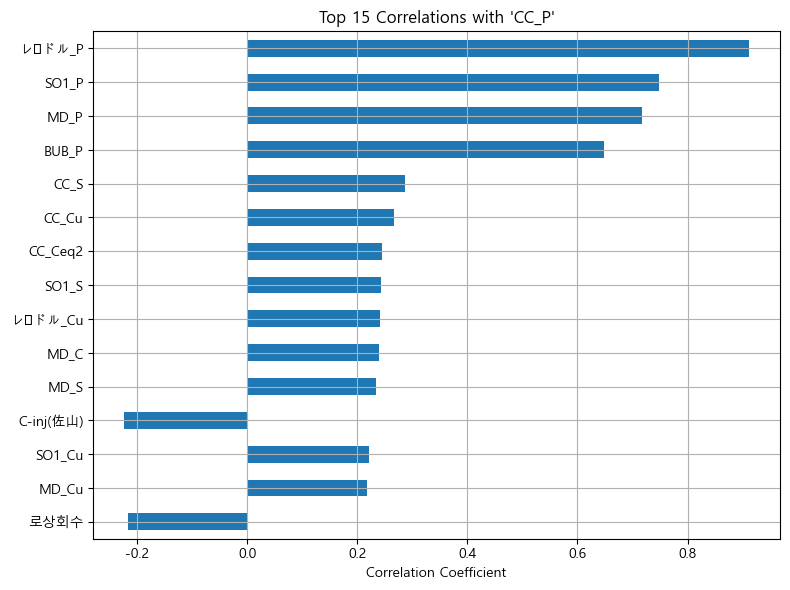

In [9]:
import matplotlib.pyplot as plt

sorted_corrs.head(top_n).plot(kind='barh', figsize=(8, 6), title=f"Top {top_n} Correlations with '{target}'")
plt.gca().invert_yaxis()  # Largest at top
plt.xlabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()